In [1]:
# importing standard packages
import pandas as pd
import numpy as np 
from scipy import stats 

# importing the plot funnctions
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

# preprocessing/ model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# importing the classifiers 
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# importing the metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report,f1_score
from sklearn.metrics import roc_curve

# oversampling techniques 
from imblearn.over_sampling import SMOTE

# importing model saving package 
from joblib import dump, load

from sklearn import preprocessing



/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and wil

The calibration allows us to better calibrate the probabilities of a given model, or to add support for probability prediction.

Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approximately 80% actually belong to the positive class.

We switch our probability from 0.5 to 0.8, but there is not a significant change of result. We increase the precision but sacrifice the recall socre, which is what we really care about in our predication.



# Functions

In [26]:
def metrics_imbalanced(your_confusion_matrix, y_true, y_proba):
    
    """
    Print precision, recall, fallout and auroc score based on the confusion matrix. 
    
    Parameters:
    ------------------
    your_confusion_matrix:                ndarray of shape (n_classes, n_classes) 
                                          confusion matrix
                                          
    y_true:                               array-like of shape (n_samples,) 
                                          True label of target (y)
                                          
    y_proba:                              y_proba             array-like of shape (n_samples,)
                                          The predicted probability of target (y)
    """
    
    # Model evaluation metrics. 
    tp = your_confusion_matrix[1,1]
    fn = your_confusion_matrix[1,0]
    fp = your_confusion_matrix[0,1]
    tn = your_confusion_matrix[0,0]
    auroc = roc_auc_score(y_true, y_proba)
    
    print('Precision = %0.5f'%(tp/(tp+fp)))
    print('Recall (TPR) = %0.5f'%(tp/(tp+fn)))
    print('Fallout (FPR) = %0.5f'%(fp/(fp+tn)))
    print('Roc_auc_score = %0.5f'%auroc)

In [29]:
def draw_roc_curve(y_true, y_proba):
    
    """
    Draw baseline and model roc curve
    
    Parameters:
    ------------------
    y_true:             array-like of shape (n_samples,) 
                        True label of target (y)
                        
    y_proba             array-like of shape (n_samples,)
                        The predicted probability of target (y)
    """
    
    
    base_fpr, base_tpr, _ = roc_curve(y_true, [1 for _ in range(len(y_true))])
    model_fpr, model_tpr, _ = roc_curve(y_true, y_proba)
    auroc = roc_auc_score(y_true, y_proba)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    
    return ax

In [2]:
# load model 
lgb_u_best = load('LGB_U_tuned.joblib')

/Users/Jenny/.local/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
# load X_test and y_test
%store -r X_test
%store -r y_test

In [21]:
# make predictions
y_pred = lgb_u_best.predict(X_test)
y_proba = lgb_u_best.predict_proba(X_test)[:,1]

# Probability calibration with f1

Maximum f1-score is 0.5120375807398708 when criterion is 0.8


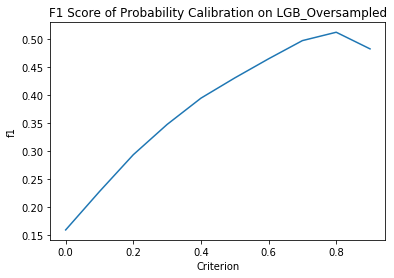

In [22]:
criterion = []
f1 = []

for i in np.arange(0,1,0.1):
    criterion.append(i)
    
    y_pred_tweak = y_proba>i
    y_pred_tweak = y_pred_tweak*1
    f1.append(f1_score(y_test.values.ravel(), y_pred_tweak))
    
fig, ax = plt.subplots()
ax = sns.lineplot(criterion, f1)
ax.set_title("F1 Score of Probability Calibration on LGB_Oversampled")
ax.set_xlabel('Criterion')
ax.set_ylabel('f1')

print("Maximum f1-score is", max(f1), "when criterion is {}".format(criterion[f1.index(max(f1))]))

If we move our threshold to 0.8, we may end up predicting less positives, which may lead to a lower recall (TPR)

In [23]:
y_pred_best_f1 = y_proba>.8
y_pred_best_f1 = y_pred_best_f1*1

In [28]:
# generate confusion matrix
cm = confusion_matrix(y_test, y_pred_best_f1)

# show metrics
metrics_imbalanced(cm, y_test, y_proba)
print('f1 =', f1_score(y_test, y_pred_best_f1))

Precision = 0.47833
Recall (TPR) = 0.55085
Fallout (FPR) = 0.05674
Roc_auc_score = 0.89970
f1 = 0.5120375807398708


# ROC curve

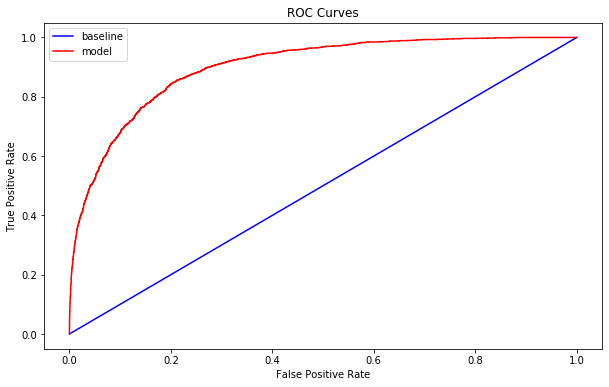

In [30]:
draw_roc_curve(y_test, y_proba)

# Precision-recall curve

In [32]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_proba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.55


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.55')

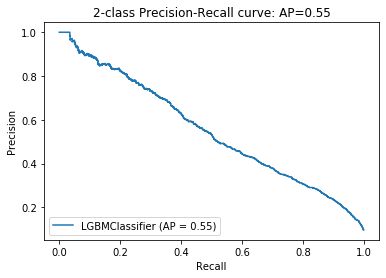

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lgb_u_best, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))